In [1]:
# Import 
import networkx as nx
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
edges_df = pd.read_csv('data/api_data/station_distances.csv')
edges_df['DistanceRatio'] = edges_df['DistanceMiles'] / edges_df['DistanceMinutes']
edges_df.head()

,FromStationCode,ToStationCode,DistanceMiles,DistanceMinutes,DistanceRatio
0,A01,A02,0.75,2.0,0.375000
1,A01,A03,1.23,4.0,0.307500
2,A01,A04,2.40,6.0,0.400000
3,A01,A05,3.10,9.0,0.344444
4,A01,A06,3.73,11.0,0.339091


In [3]:
print(len(edges_df))

10468


In [34]:
# Grab node location data'
station_list_path = 'data/api_data/station_list.xml'
node_locations = pd.read_xml(station_list_path, xpath='./wm:Stations/wm:Station', namespaces={'wm': 'http://www.wmata.com'})
node_locations = node_locations[['Code', 'Lat', 'Lon']]
node_locations.head()
scale = 2
pos = {code: (long*scale, lat*scale) for code, long, lat in zip(node_locations['Code'], node_locations['Lon'], node_locations['Lat'])}

In [5]:
station_list_path = 'data/api_data/station_list.xml'
station_info = pd.read_xml(station_list_path, xpath='./wm:Stations/wm:Station', namespaces={'wm': 'http://www.wmata.com'})
station_info['LineComb'] = station_info['LineCode1'] + station_info['LineCode2'].fillna('') + station_info['LineCode3'].fillna('') + station_info['LineCode4'].fillna('')

print(station_info.head())

              Address Code        Lat LineCode1 LineCode2 LineCode3  \
0  \n                  A01  38.898303        RD      None      None   
1  \n                  A02  38.903192        RD      None      None   
2  \n                  A03  38.909499        RD      None      None   
3  \n                  A04  38.924999        RD      None      None   
4  \n                  A05  38.934703        RD      None      None   

   LineCode4        Lon                           Name StationTogether1  \
0        NaN -77.028099                   Metro Center              C01   
1        NaN -77.039766                 Farragut North             None   
2        NaN -77.043620                  Dupont Circle             None   
3        NaN -77.052648  Woodley Park-Zoo/Adams Morgan             None   
4        NaN -77.058226                 Cleveland Park             None   

   StationTogether2 LineComb  
0               NaN       RD  
1               NaN       RD  
2               NaN       RD 

In [6]:
colors = ['r', 'g', 'b', 'silver', 'orange', 'yellow']
def get_edge_color(row):
    if row['LineComb'] == 'RD':
        return 'red'
    elif row['LineComb'] == 'BL':
        return 'blue'
    elif row['LineComb'] == 'YL':
        return 'yellow'
    elif row['LineComb'] == 'OR':
        return 'orange'
    elif row['LineComb'] == 'GR':
        return 'green'
    elif row['LineComb'] == 'SV':
        return 'silver'
    elif row['LineComb'] == 'BLORSV':
        return 'darkkhaki'
    elif row['LineComb'] == 'BLYL':
        return 'darkgreen'
    elif row['LineComb'] == 'GRYL':
        return 'lime'
    elif row['LineComb'] == 'BLSV':
        return 'lightskyblue'
    elif row['LineComb'] == 'ORSV':
        return 'salmon'
    else:
        return 'black'  # default color (black) for undefined combinations

station_info['LineColor'] = station_info.apply(get_edge_color, axis=1)
node_colormap = station_info['LineColor'].to_list()
station_info.head()

,Address,Code,Lat,LineCode1,LineCode2,LineCode3,LineCode4,Lon,Name,StationTogether1,StationTogether2,LineComb,LineColor
0,\n,A01,38.898303,RD,None,None,NaN,-77.028099,Metro Center,C01,NaN,RD,red
1,\n,A02,38.903192,RD,None,None,NaN,-77.039766,Farragut North,None,NaN,RD,red
2,\n,A03,38.909499,RD,None,None,NaN,-77.043620,Dupont Circle,None,NaN,RD,red
3,\n,A04,38.924999,RD,None,None,NaN,-77.052648,Woodley Park-Zoo/Adams Morgan,None,NaN,RD,red
4,\n,A05,38.934703,RD,None,None,NaN,-77.058226,Cleveland Park,None,NaN,RD,red


In [7]:
# Create custom legend
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='yellow', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='silver', lw=4),
                Line2D([0], [0], color='darkkhaki', lw=4),
                Line2D([0], [0], color='darkgreen', lw=4),
                Line2D([0], [0], color='lime', lw=4),
                Line2D([0], [0], color='lightskyblue', lw=4),
                Line2D([0], [0], color='salmon', lw=4),
                Line2D([0], [0], color='black', lw=4)]
legend_labels = ['Red Line', 'Blue Line', 'Yellow Line', 'Orange Line', 'Green Line', 'Silver Line',
                 'Blue-Orange-Silver', 'Blue-Yellow', 'Green-Yellow', 'Blue-Silver', 'Orange-Silver', 'Other']

In [8]:
# Create network graph from Edges in Minutes
G = nx.from_pandas_edgelist(edges_df, source='FromStationCode', target='ToStationCode', edge_attr='DistanceRatio')


In [9]:
print(G.nodes())

['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B35', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11', 'D12', 'D13', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07', 'E08', 'E09', 'E10', 'F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'G01', 'G02', 'G03', 'G04', 'G05', 'J02', 'J03', 'K01', 'K02', 'K03', 'K04', 'K05', 'K06', 'K07', 'K08', 'N01', 'N02', 'N03', 'N04', 'N06', 'N07', 'N08', 'N09', 'N10', 'N11', 'N12']


In [10]:
# Let's filter edge list and only show edges with DistanceRatio > 0.7
# is possible with 
fastest_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['DistanceRatio'] > 0.7]
print(fastest_edges)

[('A10', 'A11', {'DistanceRatio': 0.7433333333333333}), ('C13', 'J02', {'DistanceRatio': 0.756}), ('D07', 'G01', {'DistanceRatio': 0.735}), ('D08', 'G01', {'DistanceRatio': 0.7733333333333333}), ('E08', 'E10', {'DistanceRatio': 0.7016666666666667}), ('E09', 'E10', {'DistanceRatio': 0.8166666666666668}), ('K07', 'K08', {'DistanceRatio': 0.8266666666666667}), ('N04', 'N06', {'DistanceRatio': 0.70625})]


In [12]:
# Get Station->Station name info for text print
station_name_map = {row['Code']: row['Name'] for _, row in station_info.iterrows()}
edges_df['FromName'] = edges_df['FromStationCode'].map(station_name_map)
edges_df['ToName'] = edges_df['ToStationCode'].map(station_name_map)
fastest_edges_df = edges_df[edges_df['DistanceRatio'] > 0.7].copy()
fastest_edges_str = "\n".join([f"{row.FromName}({row.FromStationCode}), {row.ToName}({row.ToStationCode}): {row.DistanceMiles} miles over {row.DistanceMinutes} minutes" for _, row in fastest_edges_df.iterrows()])
print(fastest_edges_str)

Medical Center(A10), Grosvenor-Strathmore(A11): 2.23 miles over 3.0 minutes
Grosvenor-Strathmore(A11), Medical Center(A10): 2.23 miles over 3.0 minutes
King St-Old Town(C13), Van Dorn Street(J02): 3.78 miles over 5.0 minutes
Potomac Ave(D07), Benning Road(G01): 2.94 miles over 4.0 minutes
Stadium-Armory(D08), Benning Road(G01): 2.32 miles over 3.0 minutes
Hyattsville Crossing(E08), Greenbelt(E10): 4.21 miles over 6.0 minutes
College Park-U of Md(E09), Greenbelt(E10): 2.45 miles over 3.0 minutes
Greenbelt(E10), Hyattsville Crossing(E08): 4.21 miles over 6.0 minutes
Greenbelt(E10), College Park-U of Md(E09): 2.45 miles over 3.0 minutes
Benning Road(G01), Potomac Ave(D07): 2.94 miles over 4.0 minutes
Benning Road(G01), Stadium-Armory(D08): 2.32 miles over 3.0 minutes
Van Dorn Street(J02), King St-Old Town(C13): 3.78 miles over 5.0 minutes
Dunn Loring-Merrifield(K07), Vienna/Fairfax-GMU(K08): 2.48 miles over 3.0 minutes
Vienna/Fairfax-GMU(K08), Dunn Loring-Merrifield(K07): 2.48 miles over 

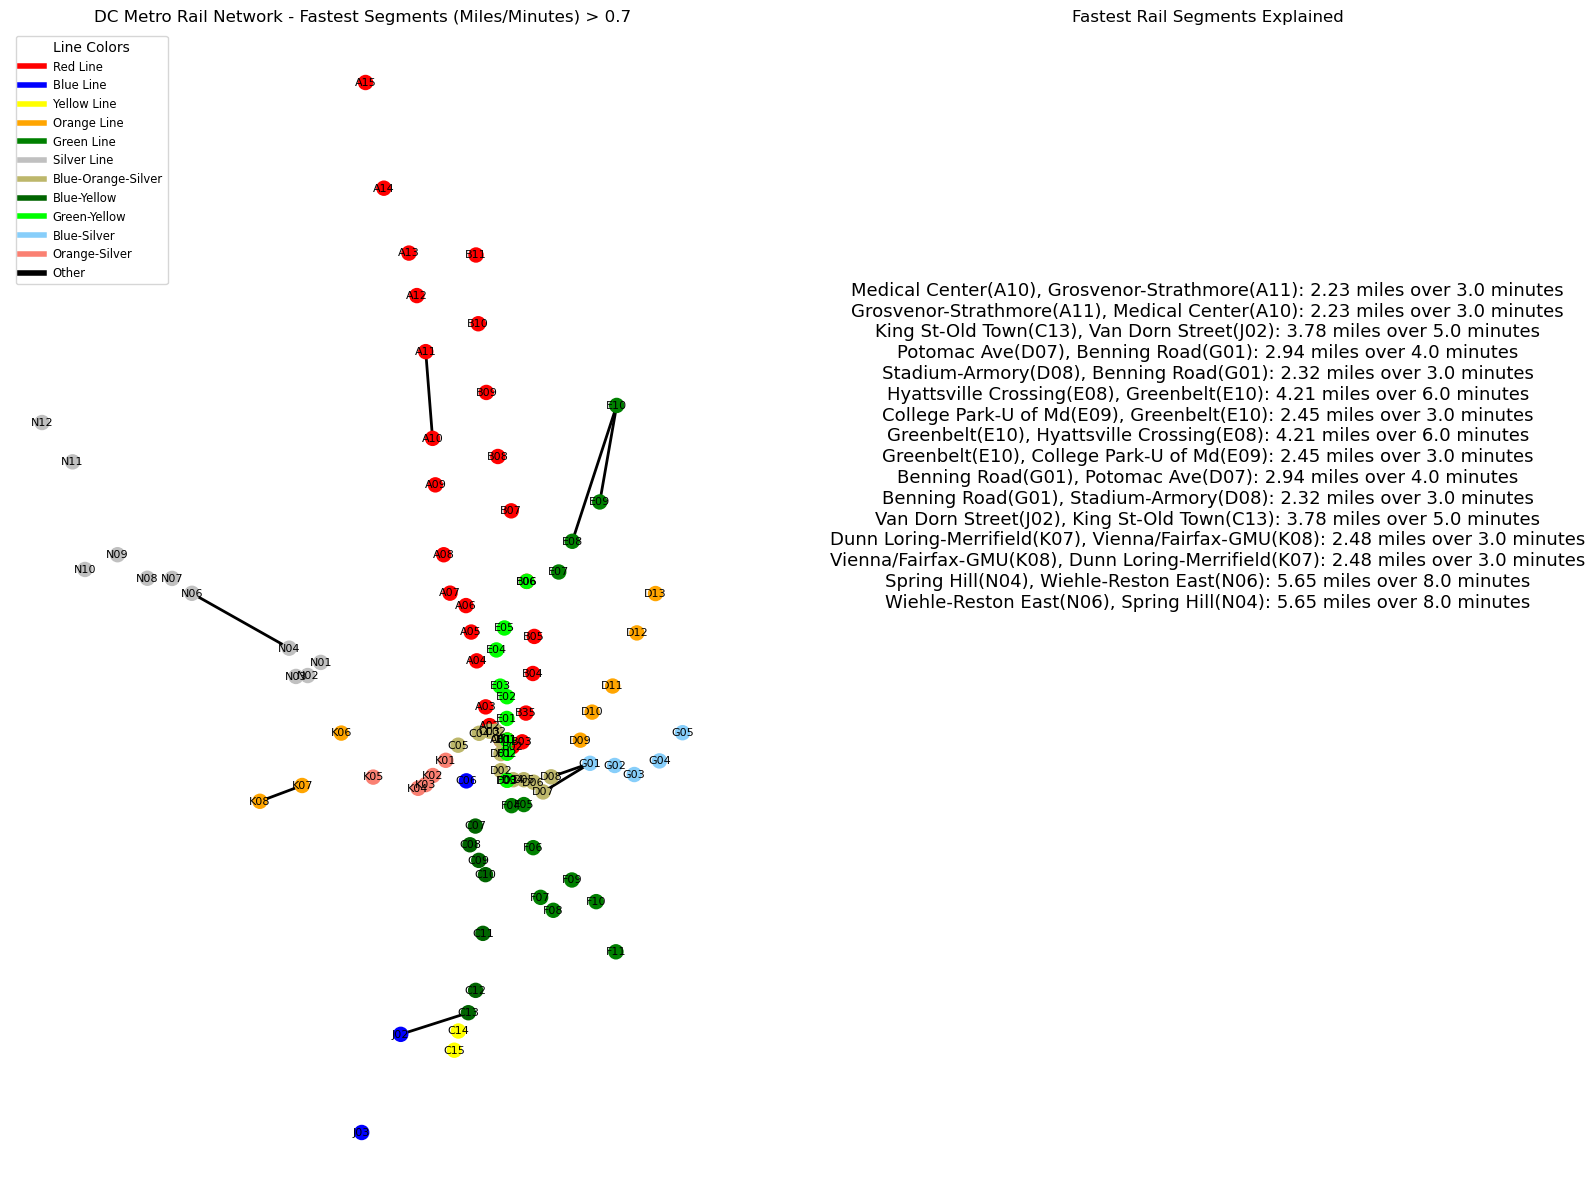

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
nx.draw(G, 
        with_labels=True,
        ax=ax1,
        pos=pos, 
        node_color=node_colormap, 
        edgelist=fastest_edges, 
        node_size=100,
        width=2,
        linewidths=1.1,
        font_size=8
        )
ax2.text(0.5, 0.5, fastest_edges_str, fontsize=13, va='baseline', ha='center')
ax2.axis('off')
ax1.set_title('DC Metro Rail Network - Fastest Segments (Miles/Minutes) > 0.7')
ax1.legend(custom_lines, legend_labels, loc='upper left', fontsize='small', title='Line Colors')
ax2.set_title('Fastest Rail Segments Explained')
plt.savefig('dc_metro_fastest_segments.png', dpi=300)
plt.show()

In [24]:
# Let's filter edge list and only show edges with DistanceRatio < 0.2
# is possible with 
slowest_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['DistanceRatio'] < 0.1]
print(slowest_edges)

[('A01', 'E01', {'DistanceRatio': 0.08333333333333333}), ('A01', 'F02', {'DistanceRatio': 0.07}), ('A02', 'C03', {'DistanceRatio': 0.09777777777777778}), ('B01', 'C02', {'DistanceRatio': 0.08375}), ('B01', 'D01', {'DistanceRatio': 0.0625}), ('B01', 'D02', {'DistanceRatio': 0.086}), ('B02', 'D01', {'DistanceRatio': 0.079}), ('B02', 'D02', {'DistanceRatio': 0.09000000000000001}), ('B02', 'D04', {'DistanceRatio': 0.075}), ('B02', 'D05', {'DistanceRatio': 0.08833333333333333}), ('B02', 'E01', {'DistanceRatio': 0.09444444444444444}), ('B02', 'F02', {'DistanceRatio': 0.0675}), ('B03', 'D04', {'DistanceRatio': 0.09000000000000001}), ('B03', 'D05', {'DistanceRatio': 0.093}), ('C01', 'E01', {'DistanceRatio': 0.08333333333333333}), ('C01', 'F02', {'DistanceRatio': 0.07}), ('C02', 'E01', {'DistanceRatio': 0.06733333333333333}), ('C02', 'E02', {'DistanceRatio': 0.088125}), ('C02', 'E03', {'DistanceRatio': 0.09388888888888888}), ('C02', 'F01', {'DistanceRatio': 0.08375}), ('C02', 'F02', {'DistanceR

In [27]:
# Get Station->Station name info for text print
slowest_edges_df = edges_df[edges_df['DistanceRatio'] < 0.07].copy()
slowest_edges_str = "\n".join([f"{row.FromName}({row.FromStationCode}), {row.ToName}({row.ToStationCode}): {row.DistanceMiles} miles over {row.DistanceMinutes} minutes" for _, row in slowest_edges_df.iterrows()])
print(slowest_edges_str)

Gallery Pl-Chinatown(B01), Federal Triangle(D01): 0.5 miles over 8.0 minutes
Judiciary Square(B02), Archives-Navy Memorial-Penn Quarter(F02): 0.54 miles over 8.0 minutes
McPherson Square(C02), Mt Vernon Sq 7th St-Convention Center(E01): 1.01 miles over 15.0 minutes
McPherson Square(C02), Mt Vernon Sq 7th St-Convention Center(E01): 1.01 miles over 15.0 minutes
Federal Triangle(D01), Gallery Pl-Chinatown(B01): 0.5 miles over 8.0 minutes
Federal Triangle(D01), Gallery Pl-Chinatown(F01): 0.5 miles over 8.0 minutes
Federal Triangle(D01), Archives-Navy Memorial-Penn Quarter(F02): 0.64 miles over 11.0 minutes
Mt Vernon Sq 7th St-Convention Center(E01), McPherson Square(C02): 1.01 miles over 15.0 minutes
Gallery Pl-Chinatown(F01), Federal Triangle(D01): 0.5 miles over 8.0 minutes
Archives-Navy Memorial-Penn Quarter(F02), Judiciary Square(B02): 0.54 miles over 8.0 minutes
Archives-Navy Memorial-Penn Quarter(F02), Federal Triangle(D01): 0.64 miles over 11.0 minutes


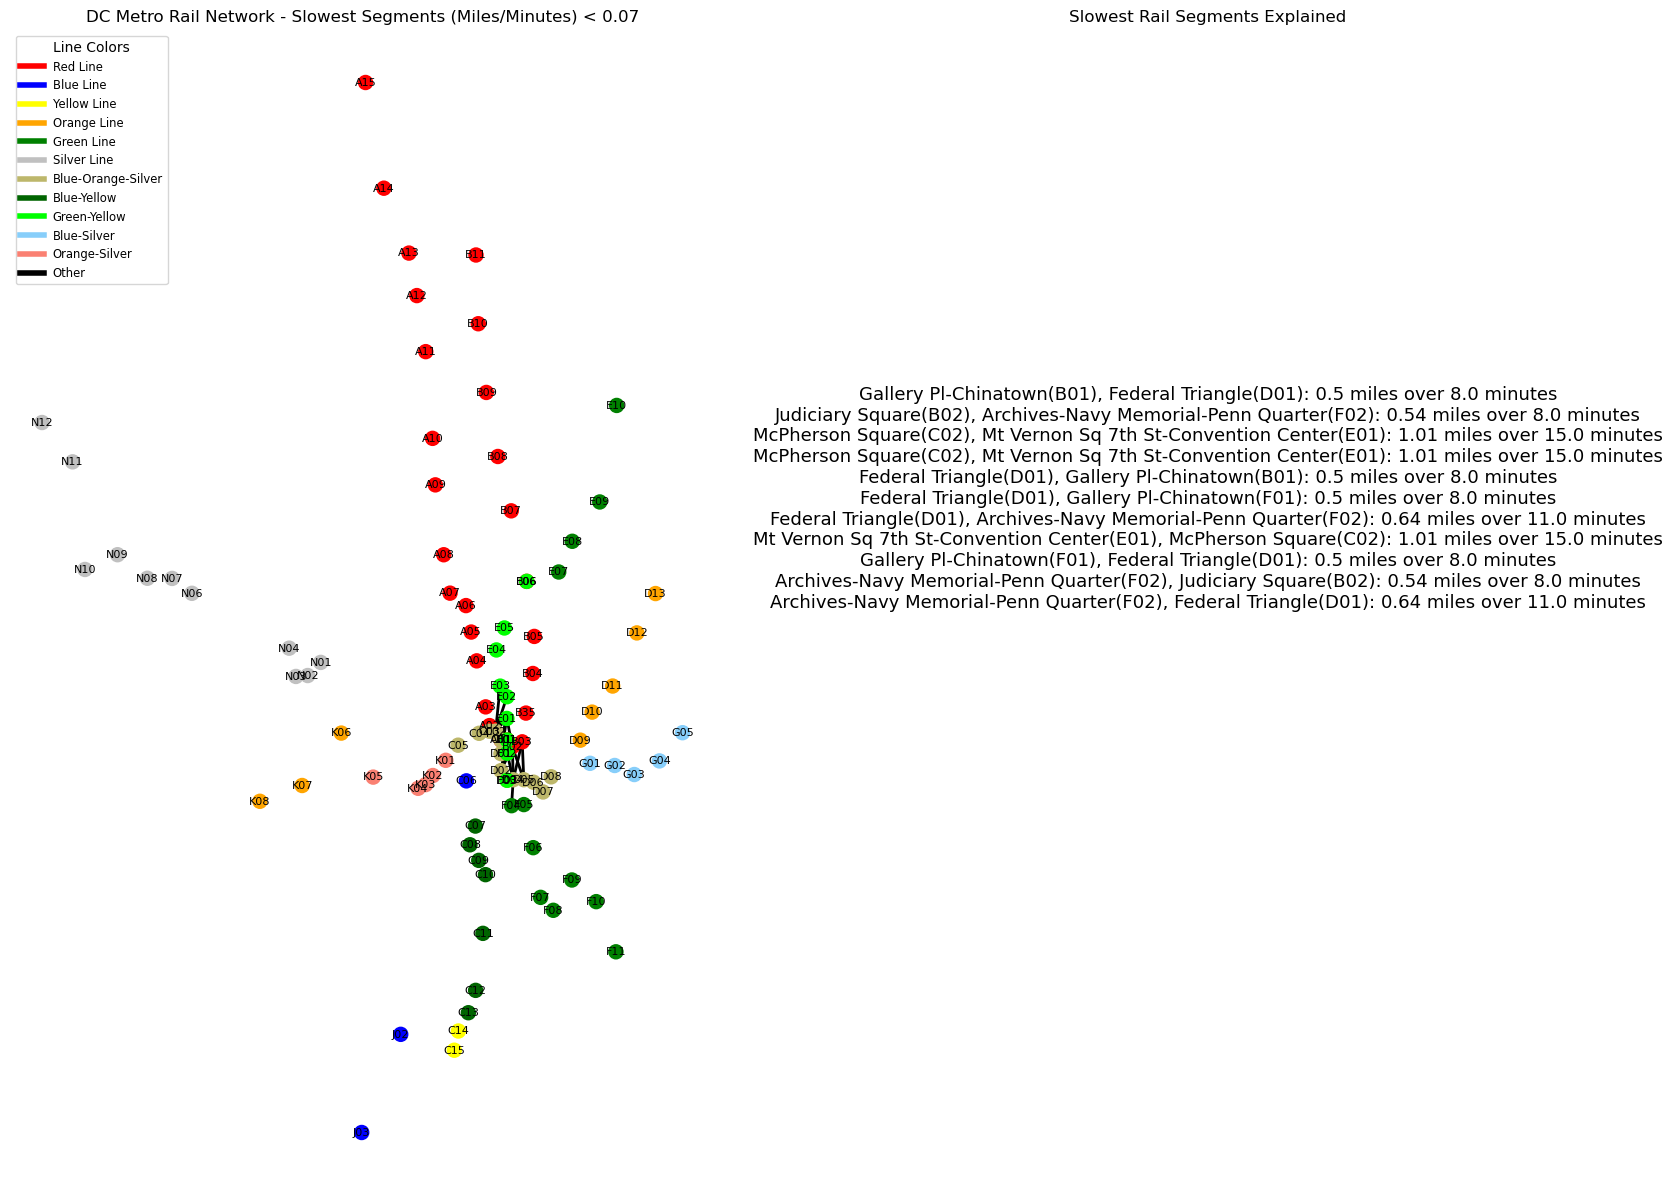

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
nx.draw(G, 
        with_labels=True,
        ax=ax1,
        pos=pos, 
        node_color=node_colormap, 
        edgelist=slowest_edges, 
        node_size=100,
        width=2,
        linewidths=1.1,
        font_size=8
        )
ax2.text(0.5, 0.5, slowest_edges_str, fontsize=13, va='baseline', ha='center')
ax2.axis('off')
ax1.set_title('DC Metro Rail Network - Slowest Segments (Miles/Minutes) < 0.07')
ax1.legend(custom_lines, legend_labels, loc='upper left', fontsize='small', title='Line Colors')
ax2.set_title('Slowest Rail Segments Explained')
plt.savefig('dc_metro_slowest_segments.png', dpi=300)
plt.show()